# Spectral models in Gammapy

## Introduction

This notebook explains how to use the functions and classes in [gammapy.spectrum.models](http://docs.gammapy.org/dev/spectrum/#module-gammapy.spectrum.models) in order to work with spectral models.

The following clases will be used:

* [gammapy.spectrum.models.PowerLaw](http://docs.gammapy.org/dev/api/gammapy.spectrum.models.PowerLaw.html)
* [gammapy.utils.modelling.Parameter](http://docs.gammapy.org/dev/api/gammapy.utils.modeling.Parameter.html)
* [gammapy.utils.modelling.ParameterList](http://docs.gammapy.org/dev/api/gammapy.utils.modeling.ParameterList.html)
* [gammapy.spectrum.models.SpectralModel](http://docs.gammapy.org/dev/api/gammapy.spectrum.models.SpectralModel.html)

## Setup

Same procedure as in every script ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from gammapy.spectrum import models
from gammapy.utils.modeling import Parameter, ParameterList

## Create a model

To create a spectral model, instantiate an object of the spectral model class you're interested in.

In [3]:
pwl = models.PowerLaw()
print(pwl)

PowerLaw

Parameters: 

	   name     value   error       unit      min max frozen
	--------- --------- ----- --------------- --- --- ------
	    index 2.000e+00   nan                 nan nan  False
	amplitude 1.000e-12   nan 1 / (cm2 s TeV) nan nan  False
	reference 1.000e+00   nan             TeV nan nan   True


This will use default values for the model parameters, which is rarely what you want.

Usually you will want to specify the parameters on object creation.
One way to do this is to pass `astropy.utils.Quantity` objects like this:

In [4]:
pwl = models.PowerLaw(
    index=2.3 * u.Unit(''),
    amplitude=1e-12 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.TeV,
)
print(pwl)

PowerLaw

Parameters: 

	   name     value   error       unit      min max frozen
	--------- --------- ----- --------------- --- --- ------
	    index 2.300e+00   nan                 nan nan  False
	amplitude 1.000e-12   nan 1 / (cm2 s TeV) nan nan  False
	reference 1.000e+00   nan             TeV nan nan   True


As you see, some of the parameters have default ``min`` and ``values`` as well as a ``frozen`` flag. This is only relevant in the context of spectral fitting and thus covered in [spectrum_analysis.ipynb](https://github.com/gammapy/gammapy-extra/blob/master/notebooks/spectrum_analysis.ipynb). Also, the parameter errors are not set. This will be covered later in this tutorial.

## Get and set model parameters

The model parameters are stored as ``ParameterList`` on the spectal model. Each model parameter is ``Parameter`` instance. It has a ``value`` and a ``unit`` attribute, as well as a ``quantity`` property for convenience.

In [5]:
print(pwl.parameters)

print(pwl.parameters['index'])
pwl.parameters['index'].value=2.6
print(pwl.parameters['index'])

print(pwl.parameters['amplitude'])
pwl.parameters['amplitude'].quantity = 2e-12 * u.Unit('m-2 TeV-1 s-1')
print(pwl.parameters['amplitude'])

ParameterList
Parameter(name='index', value=2.3, unit='', min=nan, max=nan, frozen=False)
Parameter(name='amplitude', value=1e-12, unit='1 / (cm2 s TeV)', min=nan, max=nan, frozen=False)
Parameter(name='reference', value=1.0, unit='TeV', min=nan, max=nan, frozen=True)

Covariance: 
None
Parameter(name='index', value=2.3, unit='', min=nan, max=nan, frozen=False)
Parameter(name='index', value=2.6, unit='', min=nan, max=nan, frozen=False)
Parameter(name='amplitude', value=1e-12, unit='1 / (cm2 s TeV)', min=nan, max=nan, frozen=False)
Parameter(name='amplitude', value=2e-12, unit='1 / (m2 s TeV)', min=nan, max=nan, frozen=False)


## List available models

All spectral models in gammapy are subclasses of ``SpectralModel``. The list of available models is shown below.

In [6]:
models.SpectralModel.__subclasses__()

[gammapy.spectrum.models.ExponentialCutoffPowerLaw,
 gammapy.spectrum.models.CompoundSpectralModel,
 gammapy.spectrum.models.PowerLaw2,
 gammapy.spectrum.models.PowerLaw,
 gammapy.spectrum.models.ConstantModel,
 gammapy.spectrum.models.TableModel,
 gammapy.spectrum.models.PLSuperExpCutoff3FGL,
 gammapy.spectrum.models.AbsorbedSpectralModel,
 gammapy.spectrum.models.ExponentialCutoffPowerLaw3FGL,
 gammapy.spectrum.models.LogParabola,
 gammapy.spectrum.crab.MeyerCrabModel]

## Plotting

In order to plot a model you can use the ``plot`` function. It expects an energy range as argument. You can also chose flux and energy units as well as an energy power for the plot

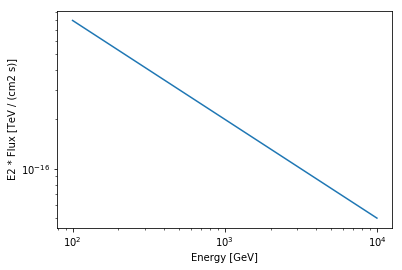

In [7]:
energy_range = [0.1, 10] * u.TeV
pwl.plot(energy_range, energy_power=2, energy_unit='GeV')

## Parameter errors

Parameters are stored internally as covariance matrix. There are, however, convenience methods to set individual parameter errors on ``ParameterList``.

In [8]:
errors = dict(
    index = 0.2 * u.Unit(''),
    amplitude = 0.1 * pwl.parameters['amplitude'].quantity
)
pwl.parameters.set_parameter_errors(errors)
print(pwl)

PowerLaw

Parameters: 

	   name     value     error        unit      min max frozen
	--------- --------- --------- -------------- --- --- ------
	    index 2.600e+00 2.000e-01                nan nan  False
	amplitude 2.000e-12 2.000e-13 1 / (m2 s TeV) nan nan  False
	reference 1.000e+00 0.000e+00            TeV nan nan   True

Covariance: 

	name/name index amplitude
	--------- ----- ---------
	    index  0.04       0.0
	amplitude   0.0     4e-26


You can access the parameter errors like this

In [9]:
print(pwl.parameters.covariance)
print(pwl.parameters.error('index'))

[[  4.00000000e-02   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   4.00000000e-26   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]]
0.2


You can plot the butterfly using the ``plot_error`` method.

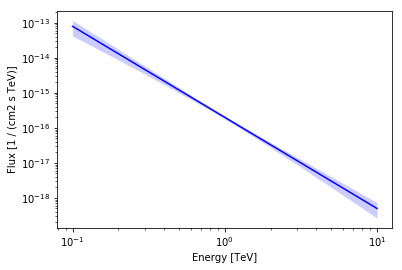

In [10]:
ax = pwl.plot_error(energy_range, color='blue', alpha=0.2)
pwl.plot(energy_range, ax=ax, color='blue')

## Integral fluxes

You've probably asked yourself already, if it's possible to integrated models. Yes, it is. Where analytical solutions are available, these are used by default. Otherwise, a numerical integration is performed.

In [11]:
integral = pwl.integral(emin=1 * u.TeV, emax= 10*u.TeV)
print(integral)

1.2186014196061302e-12 1 / (m2 s)


## User-defined model

Now we'll see how you can define a custom model. To do that you need to subclass ``SpectralModel``. All ``SpectralModel`` subclasses need to have an ``__init__`` function, which sets up the ``ParameterList`` of the model and a ``static`` function called ``evaluate`` where the mathematical expression for the model is defined.

As an example we will use a PowerLaw plus a Gaussian (with fixed width).

In [12]:
class UserModel(models.SpectralModel):
    def __init__(self, index, amplitude, reference, mean, width):
        self.parameters = ParameterList([
                Parameter('index', index, parmin=0),
                Parameter('amplitude', amplitude, parmin=0),
                Parameter('reference', reference, frozen=True),
                Parameter('mean', mean, parmin=0),
                Parameter('width', width, parmin=0, frozen=True)
            ])
    @staticmethod
    def evaluate(energy, index, amplitude, reference, mean, width):
        pwl = models.PowerLaw.evaluate(energy=energy, index=index, amplitude=amplitude, reference=reference)
        gauss = amplitude * np.exp(-1 *(energy - mean) ** 2/( 2 * width ** 2))
        return pwl + gauss

In [13]:
model = UserModel(
    index=2 * u.Unit(''),
    amplitude=1e-12 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.TeV,
    mean=5 * u.TeV,
    width=0.2 * u.TeV,
)
print(model)

UserModel

Parameters: 

	   name     value   error       unit      min max frozen
	--------- --------- ----- --------------- --- --- ------
	    index 2.000e+00   nan                 nan nan  False
	amplitude 1.000e-12   nan 1 / (cm2 s TeV) nan nan  False
	reference 1.000e+00   nan             TeV nan nan   True
	     mean 5.000e+00   nan             TeV nan nan  False
	    width 2.000e-01   nan             TeV nan nan   True


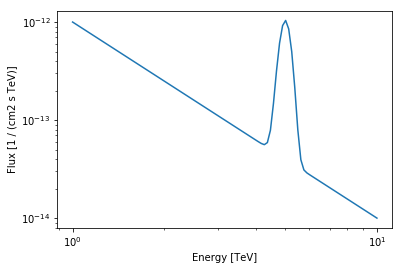

In [14]:
energy_range = [1, 10] * u.TeV

fig, ax = plt.subplots(1)
model.plot(ax=ax, energy_range=energy_range)

## What's next?

In this tutorial we learnd how to work with spectral models. Go to [gammapy.spectrum](http://docs.gammapy.org/dev/spectrum/index.html) to see what else you can do with gammapy.spectrum.